# Imports

In [1]:
import json
import av
import os
import string
import pprint as pp
from opensearchpy import OpenSearch
import pickle
import transformers
from transformers import AutoConfig, AutoModelForSequenceClassification
from bertviz import head_view

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from opensearchpy import OpenSearch
import umap
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Data Loading and Preparation

In [2]:
# Load both JSON files
with open('captions/val_1.json', 'r') as file1, open('captions/val_2.json', 'r') as file2:
    data1 = json.load(file1)
    data2 = json.load(file2)

In [3]:
def merge_timestamp_dictionaries(ident, dict1, dict2, res = {}):
    # Extract all timestamp-string pairs from both dictionaries
    pairs = []
    dic_ident = "v_" + ident
    # Add pairs from dict1
    for i in range(len(dict1[dic_ident]['timestamps'])):
        pairs.append((dict1[dic_ident]['timestamps'][i], dict1[dic_ident]['sentences'][i]))
    
    # Add pairs from dict2
    for i in range(len(dict2[dic_ident]['timestamps'])):
        pairs.append((dict2[dic_ident]['timestamps'][i], dict2[dic_ident]['sentences'][i]))
    
    # Sort pairs by timestamp
    pairs.sort(key=lambda x: x[0])
    
    # Create new merged dictionary
    res.update({ident: {
        'duration': dict2[dic_ident]["duration"],
        'timestamps': [pair[0] for pair in pairs],
        'sentences': [pair[1] for pair in pairs]
        }
               }
    )
    return res

# Video Processing

## Caption processing

In [4]:
selected_videos_ids = ["QKEFacWrn_8", "_15t4WTR19s", "eXMF6Skt2To", "TNFoUBRsngY", "od1jHUzgrAU", "gXk9TiqGUHs", "IEqnfSiCIXc", "Ez7s36AwgLk", "mHVmDOxtVt0", "i2X7z9ywHV8"]

In [5]:
# Merge the information from caption datasets for ease of use
db = {}

for entry in selected_videos_ids:
    merge_timestamp_dictionaries(entry, data1, data2, db)

## Frame extraction

In [6]:
video_dir = "videos"
videos = [os.path.join(video_dir, vid) for vid in os.listdir(video_dir) if vid.endswith(".mp4")]
videos

['videos/i2X7z9ywHV8.mp4',
 'videos/mHVmDOxtVt0.mp4',
 'videos/QKEFacWrn_8.mp4',
 'videos/gXk9TiqGUHs.mp4',
 'videos/IEqnfSiCIXc.mp4',
 'videos/od1jHUzgrAU.mp4',
 'videos/TNFoUBRsngY.mp4',
 'videos/Ez7s36AwgLk.mp4',
 'videos/eXMF6Skt2To.mp4',
 'videos/_15t4WTR19s.mp4']

In [7]:
frames = {}
video_dir = "videos"
frames_path = "frames_dict.pkl"

if os.path.exists(frames_path):
    with open(frames_path, 'rb') as f:
        try:
            frames = pickle.load(f)
        except Exception as e:
            print("Error loading pickle file:", e)


if not frames:
    for vid in selected_videos_ids:
        curr_dir = vid + "_keyframes"
        frames_saved = os.path.isdir(curr_dir)
        
        if not frames_saved:
            os.mkdir(curr_dir)
    
        """
        With this implementation we go through every frame and save them if they:
         - are a key frame, or
         - no other frame was saved within that second
    
        On top of that, we create the dictionary frames that contains every frame where:
        - the key is: video_id + "_" + number_of_saved_frame
        - the value is: another dictionary with "timestamp" and "type"
        The type is either sec - for frames saved for the second they are in - or
        key - for being a keyframe.
        """
        with av.open(os.path.join(video_dir, vid + ".mp4")) as container:
            stream = container.streams.video[0]
            last_saved_second = -1
    
            i = 0
            for j, frame in enumerate(container.decode(stream)):
                if frame.pts is None:
                    print("Something wrong here")
                    continue
                
                # Calculate the timestamp in seconds
                timestamp = float(frame.pts * stream.time_base)
                current_second = int(timestamp)
                
                # Check if this is a keyframe
                is_keyframe = frame.key_frame
                
                # Determine if we should save this frame
                save_frame = False
                frame_type = None
                
                if is_keyframe:
                    # Always save keyframes
                    save_frame = True
                    frame_type = "key"
                elif current_second > last_saved_second:
                    # Save non-keyframes only if we don't have a frame for this second yet
                    save_frame = True
                    frame_type = "sec"
                
                if save_frame:
                    i+=1
                    # Update the last second we saved a frame for
                    last_saved_second = current_second
                    
                    # Create a descriptive frame name
                    frame_name = f"{vid}_{i}"
                    name = os.path.join(curr_dir, frame_name + ".jpg")
                    
                    # Update the frames dictionary
                    frames.update({
                        frame_name: {"timestamp": timestamp,
                                     "type": frame_type
                                    }
                    })
                    
                    # Save the frame image if required
                    if not frames_saved:
                        frame.to_image().save(name, quality=80)

    with open(frames_path, 'wb') as f:
        pickle.dump(frames, f)

# OpenSearch Configuration

## Index Setup

In [8]:
host = 'api.novasearch.org'
port = 443

user = 'user08' # Add your user name here.
password = '55LL.TTSS' # Add your user password here. For testing only. Don't store credentials in code. 
index_name = user

# Create the client with SSL/TLS enabled, but hostname verification disabled.
client = OpenSearch(
    hosts = [{'host': host, 'port': port}],
    http_compress = True, # enables gzip compression for request bodies
    http_auth = (user, password),
    use_ssl = True,
    url_prefix = 'opensearch_v2',
    verify_certs = False,
    ssl_assert_hostname = False,
    ssl_show_warn = False
)

In [9]:
# Check if index exists
if client.indices.exists(index=index_name):
    resp = client.indices.open(index=index_name)
    print(resp)

    print('\n----------------------------------------------------------------------------------- INDEX SETTINGS')
    settings = client.indices.get_settings(index=index_name)
    pp.pprint(settings)

    print('\n----------------------------------------------------------------------------------- INDEX MAPPINGS')
    mappings = client.indices.get_mapping(index=index_name)
    pp.pprint(mappings)

    print('\n----------------------------------------------------------------------------------- INDEX #DOCs')
    print(client.count(index=index_name))
else:
    print("Index does not exist.")

{'acknowledged': True, 'shards_acknowledged': True}

----------------------------------------------------------------------------------- INDEX SETTINGS
{'user08': {'settings': {'index': {'creation_date': '1746628552433',
                                   'knn': 'true',
                                   'number_of_replicas': '0',
                                   'number_of_shards': '4',
                                   'provided_name': 'user08',
                                   'replication': {'type': 'DOCUMENT'},
                                   'uuid': 'mXaksWzMST6tqHiF8_E_4w',
                                   'version': {'created': '136387927'}}}}}

----------------------------------------------------------------------------------- INDEX MAPPINGS
{'user08': {'mappings': {'dynamic': 'strict',
                         'properties': {'caption': {'fields': {'keyword': {'type': 'keyword'}},
                                                    'type': 'text'},
                  

### Delete Existing Index (if needed)

In [70]:
client.indices.delete(index=index_name, ignore=[400, 404])
print(f"Index '{index_name}' deleted.")

Index 'user08' deleted.


## Mapping definitions

In [ ]:
index_body = {
   "settings": {
      "index": {
         "number_of_replicas": 0,
         "number_of_shards": 4,
         # "refresh_interval": "-1", # Keep it off for now, change it to "1s" later (for searching)
         "knn": "true"
      }
   },
   "mappings": {
      "dynamic": "strict",
      "properties": {
         "video_id": {"type": "keyword"},
         "start_timestamp": {"type": "float"},
         "end_timestamp": {"type": "float"},
         "caption": {
            "type": "text",
            "fields": {
               "keyword": {"type": "keyword"}
            }
         },
         #"caption_id": {"type": "keyword"},
         "caption_bow": {"type": "text"},
         "caption_vec": {
            "type": "knn_vector",
            "dimension": 768,
            "method": {
               "name": "hnsw",
               "space_type": "innerproduct",
               "engine": "nmslib",
               "parameters": {
                  "m": 16,
                  "ef_construction": 200,
               }
            }
         },
         "visual_caption_vec": {
            "type": "knn_vector",
            "dimension": 512,
            "method": {
               "name": "hnsw",
               "space_type": "innerproduct",
               "engine": "nmslib",
               "parameters": {
                  "m": 16,
                  "ef_construction": 200,
               }
            }
         },
         "duration": {"type": "float"},
         "resolution": {"type": "keyword"},
         "keyframe_path": {"type": "keyword"},
         "keyframe_vec": {
            "type": "knn_vector",
            "dimension": 512,
            "method": {
               "name": "hnsw",
               "space_type": "innerproduct",
               "engine": "nmslib",
               "parameters": {
                  "m": 16,
                  "ef_construction": 200,
               }
            }
         }
      }
   }
}

# Create the index
response = client.indices.create(index=index_name, body=index_body)
print(f"Index '{index_name}' created.")
# Check the index settings
settings = client.indices.get_settings(index=index_name)
print("Index settings:")
pp.pprint(settings)
# Check the index mappings
mappings = client.indices.get_mapping(index=index_name)
print("Index mappings:")
pp.pprint(mappings)

# Model Definitions

## Text embedding models

In [9]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np

# Load the pre-trained model and tokenizer
model_name = 'sentence-transformers/all-mpnet-base-v2'
tokenizer = AutoTokenizer.from_pretrained(model_name)
config = AutoConfig.from_pretrained(model_name, output_hidden_states=True, output_attentions=True)
model = AutoModel.from_pretrained(model_name, config = config)
model.eval()  # Set the model to evaluation mode

print(f"Loaded model type: {type(model)}") 

def generate_caption_embedding(caption):
    inputs = tokenizer(caption, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)  # Pass the entire dictionary
        # Mean pooling
        embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    return embeddings  

Loaded model type: <class 'transformers.models.mpnet.modeling_mpnet.MPNetModel'>


In [10]:
def generate_caption_embedding_outputs(caption):
    inputs = tokenizer(caption, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)  # Pass the entire dictionary
    return inputs, outputs

## Visual embedding models

In [11]:
from PIL import Image
import torch
import open_clip
import clip

# Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32-quickgelu', pretrained='openai')
clip_model.to(device)
clip_model.eval()

# MUDAR ESTA FUNÇAO PARA REUTILIZAR O CAPTION EMBEDDING, PARA NAO RECOMPUTAR TODAS AS VEZES
def generate_clip_embeddings(image_path, caption=None):
    try:
        # Process image
        image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
        
        with torch.no_grad():
            # Encode image
            image_features = clip_model.encode_image(image)
            image_features /= image_features.norm(dim=-1, keepdim=True)  # Normalize
            
            # Encode caption if provided
            caption_embedding = None
            if caption:
                text = clip.tokenize([caption]).to(device)
                text_features = clip_model.encode_text(text)
                text_features /= text_features.norm(dim=-1, keepdim=True)  # Normalize
                caption_embedding = text_features.cpu().numpy().flatten()
            
        # Get image embedding
        image_embedding = image_features.cpu().numpy().flatten()
        
        if len(image_embedding) == 0:
            print(f"Failed to generate image embedding for {image_path}")
            return None, None
            
        return image_embedding, caption_embedding
        
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None, None

def generate_img_clip_embeddings(image_path):
    try:
        # Process image
        image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
        
        with torch.no_grad():
            # Encode image
            image_features = clip_model.encode_image(image)
            image_features /= image_features.norm(dim=-1, keepdim=True)  # Normalize
            
        # Get image embedding
        image_embedding = image_features.cpu().numpy().flatten()
        
        if len(image_embedding) == 0:
            print(f"Failed to generate image embedding for {image_path}")
            return None
            
        return image_embedding
        
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

def generate_text_clip_embeddings(caption):
    try:
        with torch.no_grad():
            # Encode caption
            text = clip.tokenize([caption]).to(device)
            text_features = clip_model.encode_text(text)
            text_features /= text_features.norm(dim=-1, keepdim=True)  # Normalize
            
        caption_embedding = text_features.cpu().numpy().flatten()
        
        if len(caption_embedding) == 0:
            print(f"Failed to generate caption embedding for caption \"{caption}\"")
            return None
            
        return caption_embedding
        
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

# Embedding Generation & Data Indexing

In [12]:
# Get the activity dataset
with open('activity_net.v1-3.min.json', 'r') as json_data:
    activity_data = json.load(json_data)
# Specify the index name you want to check
# index_name = "wiirijo"

# Get document count for the index
doc_count = client.count(index=index_name)

if doc_count['count'] > 0:
    print("Are you sure documents arent already indexed?")
else:
    # Cycle through the videos
    for video_id in selected_videos_ids:
        video_info = db[video_id]
        duration = video_info["duration"]
        timestamps = video_info["timestamps"]
        captions = video_info["sentences"]
        caption_embeds = [None] * len(captions)
        visual_caption_embeds = [None] * len(captions)
        resolution = activity_data["database"][video_id]["resolution"]
        keyframe_dir = video_id + "_keyframes"
        keyframes = [os.path.splitext(f)[0] for f in os.listdir(keyframe_dir)]
        keyframes_embeds = [None] * len(keyframes)
    
        # Cycle through the video keyframes
        for i in range(len(keyframes)):
        #for frame_name in keyframes:

            frame_name = keyframes[i]
            kf_timestamp = frames[frame_name]["timestamp"]

            # Match frame with the captions that intersect it
            for j in range(len(timestamps)):
    
                start_time, end_time = timestamps[j]
    
                if start_time <= kf_timestamp <= end_time:
                    
                    caption = captions[j]

                    #caption_id = f"{video_id}_{start_time}_{end_time}"

                    # For the bow representation, we first remove every pontuation, followed by
                    # converting every character to lower case and finally split its elements
                    caption_bow = caption.translate(str.maketrans('', '', string.punctuation)).lower().split()
                    
                    # If the caption embedding hasnt been computed, do it, otherwise use the one saved
                    if caption_embeds[j] is None:
                        caption_embedding = generate_caption_embedding(caption)
                        caption_embeds[j] = caption_embedding
                    else:
                        caption_embedding = caption_embeds[j]

                    caption_vec = caption_embedding.tolist()
                    
                    # Same logic as above
                    if visual_caption_embeds[j] is None:
                        visual_caption_embedding = generate_text_clip_embeddings(caption)
                        visual_caption_embeds[j] = visual_caption_embedding
                    else:
                        visual_caption_embedding = visual_caption_embeds[j]

                    visual_caption_vec = visual_caption_embedding.tolist()

                    keyframe_path = os.path.join(keyframe_dir, frame_name + ".jpg")

                    # Same logic as above
                    if keyframes_embeds[i] is None:
                        keyframe_embedding = generate_img_clip_embeddings(keyframe_path)
                        keyframes_embeds[i] = keyframe_embedding
                    else:
                        keyframe_embedding = keyframes_embeds[i]
                    #keyframe_embedding, visual_caption_embedding = generate_clip_embeddings(keyframe_path, caption)
                    keyframe_vec = keyframe_embedding.tolist()
                    
                    document_id = f"{frame_name}_{j}"
                    
                    doc = {
                            'video_id': video_id,
                            'start_timestamp': start_time,
                            'end_timestamp': end_time,
                            'caption': caption,
                            #'caption_id': caption_id,
                            'caption_bow': caption_bow,
                            'caption_vec': caption_vec,
                            'visual_caption_vec': visual_caption_vec,
                            'duration': duration,
                            'resolution': resolution,
                            'keyframe_path': keyframe_path,
                            'keyframe_vec': keyframe_vec
                        }
                    
                    try:
                        response = client.index(index=index_name, id=document_id, body=doc)
                        #print(f"Indexed document for keyframe {frame_name} with caption '{caption}'")
                    except Exception as e:
                        print(f"Error indexing document for video {video_id}: {e}")
                        continue

    # Refresh the index to make the documents searchable
    client.indices.refresh(index=index_name)
    print("Index refreshed.")

Are you sure documents arent already indexed?


# Search Functionality

In [ ]:
# Get document count for the index
doc_count = client.count(index=index_name)

# Print the document count
print(f"Number of documents in {index_name}: {doc_count['count']}")

Number of documents in user08: 6028


## Text-based search

In [59]:
query = {
    "query": {
        "match": {
            "caption": "skateboarding in a park"
        }
    }
}

response = client.search(index=index_name, body=query)
print("Search Results:")
for hit in response['hits']['hits']:
    print(f"Caption: {hit['_source']['caption']}, Score: {hit['_score']}")

Search Results:
Caption: A man is skating in a skate park., Score: 8.262309
Caption: A man is skating in a skate park., Score: 8.262309
Caption: A man is skating in a skate park., Score: 8.262309
Caption: A man is skating in a skate park., Score: 8.262309
Caption: A man is skating in a skate park., Score: 8.262309
Caption: A man is skating in a skate park., Score: 8.246624
Caption: A man is skating in a skate park., Score: 8.246624
Caption: A man is skating in a skate park., Score: 8.246624
Caption:  We see men skateboarding and people watching., Score: 7.9968224
Caption: A man is skating in a skate park., Score: 7.8613725


## Semantic Search

### Semantic Search with KNN Vectors

In [60]:
import torch
from transformers import AutoTokenizer, AutoModel

# Generate embedding for your query
query_text = "A man skateboarding on a park"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.eval()

inputs = tokenizer(query_text, return_tensors='pt', padding=True, truncation=True)
with torch.no_grad():
    outputs = model(**inputs)
    query_embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Construct the query for OpenSearch
query = {
    "query": {
        "knn": {
            "caption_vec": {
                "vector": query_embedding.tolist(),
                "k": 5  # Number of nearest neighbors to retrieve
            }
        }
    }
}

response = client.search(index=index_name, body=query)
print("KNN Search Results:")
for hit in response['hits']['hits']:
    print(f"Caption: {hit['_source']['caption']}, Score: {hit['_score']}")


KNN Search Results:
Caption: A man is skating in a skate park., Score: 7.1102877
Caption: A man is skating in a skate park., Score: 7.1102877
Caption: A man is skating in a skate park., Score: 7.1102877
Caption: A man is skating in a skate park., Score: 7.1102877
Caption: A man is skating in a skate park., Score: 7.1102877
Caption: A man is skating in a skate park., Score: 7.1102877
Caption: A man is skating in a skate park., Score: 7.1102877
Caption: A man is skating in a skate park., Score: 7.1102877
Caption: A man is skating in a skate park., Score: 7.1102877
Caption: A man is skating in a skate park., Score: 7.1102877


For distinct results

In [61]:
import torch
from transformers import AutoTokenizer, AutoModel

# Generate embedding for your query
query_text = "skateboarding"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.eval()

inputs = tokenizer(query_text, return_tensors='pt', padding=True, truncation=True)
with torch.no_grad():
    outputs = model(**inputs)
    query_embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Construct the query for OpenSearch
query = {
    "query": {
        "knn": {
            "caption_vec": {
                "vector": query_embedding.tolist(),
                "k": 10  # Number of nearest neighbors to retrieve
            }
        }
    },
    "aggs": {
        "distinct_captions": {
            "terms": {
                "field": "caption.keyword",
                "size": 10
            }
        }
    }
}

response = client.search(index=index_name, body=query)
print("Distinct KNN Search Results:")
for bucket in response['aggregations']['distinct_captions']['buckets']:
    print(f"Caption: {bucket['key']}, Count: {bucket['doc_count']}")

Distinct KNN Search Results:
Caption:  Men attempt various tricks using bowling balls., Count: 84
Caption:  Other person skates on a park, then pass over the rails and turning and flipping teh skateboard., Count: 32
Caption:  Then, people talks in a bowling center, wile males trowing bowling bowls., Count: 13
Caption:   A man knocks down pins in a skating pool drop in., Count: 9
Caption:  A man is in a skateboard track, then he throws a bowling ball that goes around and hits the pins., Count: 9
Caption:  After, a man interview a male using a microphone., Count: 8
Caption:  We see skating for awhile., Count: 8
Caption: People are on front a board in a park holding bowling pins., Count: 5
Caption:   A bowling ball in a skate drop breaks something inside the drop., Count: 4
Caption:   Another man bowls a ball around bowling pins lined up in a curve on a bowling lane and the bowling ball doesn't hit any of them., Count: 4


## Boolean filters

In [62]:
bool_query = {
    "query": {
        "bool": {
            "filter": [
                {"term": {"resolution": "1920x1080"}},
                {
                    "range": {
                        "start_timestamp": {
                            "gte": 60,
                            "lte": 70
                        }
                    }
                }
            ]
            
        }
    },
    "aggs": {
        "distinct_captions": {
            "terms": {
                "field": "caption.keyword",
                "size": 10
            }
        }
    }
}

response = client.search(index=index_name, body=bool_query)
print("Distinct Boolean Query Results:")
for bucket in response['aggregations']['distinct_captions']['buckets']:
    print(f"Caption: {bucket['key']}, Count: {bucket['doc_count']}")


Distinct Boolean Query Results:
Caption: When he removes his hand from his throat,he takes another puff of the hookah and blows it out again., Count: 53
Caption:  We see the man boxing with another man., Count: 46
Caption:  The man uses the polish on his shoes., Count: 39
Caption:  He then gets fully dressed, noticing his trembling feet., Count: 14


## Combined search approaches

In [63]:
query_text = "smoking"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.eval()

inputs = tokenizer(query_text, return_tensors='pt', padding=True, truncation=True)
with torch.no_grad():
    outputs = model(**inputs)
    query_embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

query = {
    "query": {
        "bool": {
            "must": [  # Combine KNN search with other filters
                {
                    "knn": {
                        "caption_vec": {
                            "vector": query_embedding.tolist(),
                            "k": 10  # Number of nearest neighbors to retrieve
                        }
                    }
                }
            ],
            "filter": [  # Apply filters before the KNN search
                {"term": {"resolution": "1920x1080"}},
                {"range": {"duration": {"gte": 150}}}
            ]
        }
    },
    "aggs": {
        "distinct_captions": {
            "terms": {
                "field": "caption.keyword",
                "size": 10
            }
        }
    }
}

response = client.search(index=index_name, body=query)
print("Filtered KNN Search Results:")
for bucket in response['aggregations']['distinct_captions']['buckets']:
    print(f"Caption: {bucket['key']}, Count: {bucket['doc_count']}")


Filtered KNN Search Results:
Caption:  The man blows circles in the smoke., Count: 28
Caption: We see a man smoking a hookah pipe and talking to the camera., Count: 12


## Querying for embeddings

In [95]:
selected_videos_ids

['QKEFacWrn_8',
 '_15t4WTR19s',
 'eXMF6Skt2To',
 'TNFoUBRsngY',
 'od1jHUzgrAU',
 'gXk9TiqGUHs',
 'IEqnfSiCIXc',
 'Ez7s36AwgLk',
 'mHVmDOxtVt0',
 'i2X7z9ywHV8']

In [121]:
fetch_all_query = {
  "query": {
    "term": {
      "video_id.keyword": {
        "value": "_15t4WTR19s"
      }
    }
  },
  "size": 10000  # Adjust size to be larger than the total number of documents for the video, if needed
}


In [122]:
response = client.search(index=index_name, body=fetch_all_query)

In [123]:
response

{'took': 2,
 'timed_out': False,
 '_shards': {'total': 4, 'successful': 4, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 0, 'relation': 'eq'},
  'max_score': None,
  'hits': []}}

In [12]:
embedding_field = "caption_vec"  # Replace with your actual field name
sample_size = 1000  # Adjust based on your dataset size and computational resources

In [13]:
query = {
    "size": sample_size,
    "_source": [embedding_field, "caption"],
    "query": {
        "match_all": {}
    },
    "aggs": {
        "distinct_captions": {
            "terms": {
                "field": "caption.keyword",
                "size": 10
            }
        }
    }
}

In [67]:
# Execute the query
response = client.search(
    body=query,
    index=index_name
)

In [68]:
# Extract embeddings and captions
embeddings = []
captions = []
for hit in response['hits']['hits']:
    embedding = hit['_source'][embedding_field]
    caption = hit['_source']['caption']
    embeddings.append(embedding)
    captions.append(caption)

In [69]:
embeddings_array = np.array(embeddings)
print(f"Loaded {len(embeddings_array)} embeddings with dimension {embeddings_array.shape[1]}")

Loaded 1000 embeddings with dimension 768


# Visualization Tools

## Embedding Visualizations

### Visualizing contextual Embeddings

In [70]:
captions = []
for ident in selected_videos_ids:
    for sent in db[ident]["sentences"]:
        captions.append(sent)

In [71]:
captions[3]

' A man is in a skateboard track, then he throws a bowling ball that goes around and hits the pins.'

In [89]:
def generate_all_embeddings_graph(sentences):
    ins, outs = generate_caption_embedding_outputs(sentence)
    input_ids = ins['input_ids']
    input_id_list = input_ids[0].tolist() # Batch index 0
    tokens = tokenizer.convert_ids_to_tokens(input_id_list)
    layer_m = 11
    output_embeddings = outs['hidden_states'][layer_m][0]
    fig = visualize_hidden_states(hidden_states, tokens)

In [90]:
ins, outs = generate_caption_embedding_outputs(captions[3])

In [91]:
outs.keys()

odict_keys(['last_hidden_state', 'pooler_output', 'hidden_states', 'attentions'])

### Visualizing hidden states

In [92]:
# total number of layers embeddings
len(outs['hidden_states'])

13

In [43]:
input_ids = ins['input_ids']
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)
layer_m = 11
output_embeddings = outs['hidden_states'][layer_m][0]

In [38]:
f.write_html("interactive_embeddings.html")

In [81]:
def visualize_hidden_states(hidden_states, tokens, output_path=None, dpi=150):
    """
    Create a multi-panel plot of hidden states across different layers,
    and save it to a file if output_path is provided.
    
    Parameters:
    - hidden_states: List of hidden state tensors from different layers
    - tokens: List of token strings
    - output_path: Path to save the figure (optional)
    - dpi: Resolution for saved image (higher values = larger file, better quality)
    
    Returns:
    - fig: The matplotlib figure object
    """
    rows = 3
    cols = 4
    num_layers = min(rows * cols, len(hidden_states))
    
    # Create figure and subplots
    fig, ax_full = plt.subplots(rows, cols, figsize=(cols*4+3, rows*4))
    plt.rcParams.update({'font.size': 10})
    
    # Plot each layer
    layer = 0
    for r in range(rows):
        for c in range(cols):
            if layer >= num_layers:
                # Hide unused subplots
                ax_full[r, c].axis('off')
                continue
                
            ax = ax_full[r, c]
            
            # Get current hidden state and convert to numpy if needed
            current_hidden_state = hidden_states[layer][0]
            if hasattr(current_hidden_state, 'detach'):
                current_hidden_state = current_hidden_state.detach().numpy()
            
            # Apply PCA if needed
            if current_hidden_state.shape[1] == 2:
                twodim = current_hidden_state
            else:
                twodim = PCA().fit_transform(current_hidden_state)[:, :2]
            
            # Create scatter plot
            ax.scatter(twodim[:, 0], twodim[:, 1], edgecolors='k', c='r')
            
            # Add text labels
            for word, (x, y) in zip(tokens, twodim):
                # Clean token if needed (removing special characters)
                token_text = word[1:] if word.startswith(('#', '@', '!')) else word
                ax.text(x+0.05, y+0.05, token_text)
            
            # Set title for this subplot
            ax.set_title(f"Layer {layer}", fontsize=12)
            ax.grid(True, linestyle='--', alpha=0.7)
            
            # Increment layer counter
            layer += 1
    
    # Add overall title
    fig.suptitle("Visualization of Output Embeddings Across All Layers", 
                fontsize=16, y=0.98)
    
    # Adjust layout
    plt.tight_layout()
    fig.subplots_adjust(top=0.92)
    
    # Save figure if output path is provided
    if output_path:
        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(output_path) if os.path.dirname(output_path) else '.', 
                   exist_ok=True)
        
        # Save with different formats based on extension
        extension = os.path.splitext(output_path)[1].lower()
        
        if extension == '.png':
            fig.savefig(output_path, dpi=dpi, bbox_inches='tight')
        elif extension == '.pdf':
            fig.savefig(output_path, format='pdf', bbox_inches='tight')
        elif extension == '.svg':
            fig.savefig(output_path, format='svg', bbox_inches='tight')
        elif extension == '.jpg' or extension == '.jpeg':
            fig.savefig(output_path, format='jpg', dpi=dpi, bbox_inches='tight', 
                       quality=95, optimize=True)
        else:
            # Default to PNG if extension not recognized
            fig.savefig(output_path + '.png', dpi=dpi, bbox_inches='tight')
            
        print(f"Figure saved to {output_path}")
    
    # Return the figure object
    return fig

In [93]:
fig = visualize_hidden_states(hidden_states, tokens)

NameError: name 'hidden_states' is not defined

In [55]:
fig.savefig("hidden_layers.png")

### Visualizing positional embeddings

In [76]:
ins, outs = generate_caption_embedding_outputs("ball ball ball ball ball ball ball ball ball ball ball ball ball ball ball ball ball ball ball")

In [77]:
input_ids = ins['input_ids']
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)
output_embeddings = outs.last_hidden_state[0]

In [78]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def display_scatterplot(data, words, filename="scatterplot.png"):
    if data.shape[1] == 2:
        twodim = data
    else:
        pca = PCA()
        pca.fit(data)
        twodim = pca.transform(data)[:, :2]
    
    plt.style.use('default')
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    
    for word, (x, y) in zip(words, twodim):
        plt.text(x + 0.05, y + 0.05, word)
    
    plt.xlim(-1, 1)  # Set x-axis range
    plt.tight_layout()
    plt.savefig(filename)  # Save the plot
    plt.close()  # Prevent re-display in some environments

display_scatterplot(output_embeddings.detach().numpy(), tokens, "pos_embeds.png")

In [79]:
plt.show()

In [80]:
output_embeddings.detach().numpy()

array([[-0.10207481, -0.08822922,  0.03056179, ...,  0.03742896,
        -0.03212436, -0.00422881],
       [-0.11881364,  0.02497547, -0.01503671, ...,  0.10516781,
        -0.03160025, -0.01068128],
       [-0.14782523,  0.04355097,  0.00583182, ...,  0.09683295,
        -0.05589344, -0.01374314],
       ...,
       [-0.1699806 ,  0.15894663,  0.03388931, ...,  0.06924164,
        -0.06251905,  0.02850354],
       [-0.17195293,  0.23085742,  0.04460301, ...,  0.06523876,
        -0.06394424, -0.00177262],
       [-0.11823333, -0.09104094,  0.1055546 , ...,  0.00331477,
        -0.09950992,  0.00708322]], dtype=float32)

## Attention Visualizations

### Attention cross-encoder

In [21]:
def call_html():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/5.7.0/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))
    
def display_scatterplot(model, words):

    if model.shape[1] == 2:
        twodim = model
    else:
        twodim = PCA().fit_transform(model)[:,:2]
    
    plt.style.use('ggplot')
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)


In [22]:
model_path = 'cross-encoder/ms-marco-MiniLM-L-12-v2'

transformers.logging.set_verbosity_warning()

tokenizer = AutoTokenizer.from_pretrained(model_path)
config = AutoConfig.from_pretrained(model_path,  output_hidden_states=True, output_attentions=True)  
model = AutoModelForSequenceClassification.from_pretrained(model_path, config=config)
model.eval()

/home/wiirijo/anaconda3/envs/mpdw/lib/python3.9/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/791 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 384, padding_idx=0)
      (position_embeddings): Embedding(512, 384)
      (token_type_embeddings): Embedding(2, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), eps=1e-12,

In [23]:
captions[3]

' A man is in a skateboard track, then he throws a bowling ball that goes around and hits the pins.'

In [24]:
query = "where is the man?"
document = captions[3]

inputs = tokenizer.encode_plus(query, document, return_tensors='pt', padding=True, truncation=True)
input_ids = inputs['input_ids']
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)
print("Tokens: ", tokens)
print("Input IDs: ", input_id_list)
print("Token Length: ", len(tokens))

Tokens:  ['[CLS]', 'where', 'is', 'the', 'man', '?', '[SEP]', 'a', 'man', 'is', 'in', 'a', 'skate', '##board', 'track', ',', 'then', 'he', 'throws', 'a', 'bowling', 'ball', 'that', 'goes', 'around', 'and', 'hits', 'the', 'pins', '.', '[SEP]']
Input IDs:  [101, 2073, 2003, 1996, 2158, 1029, 102, 1037, 2158, 2003, 1999, 1037, 17260, 6277, 2650, 1010, 2059, 2002, 11618, 1037, 9116, 3608, 2008, 3632, 2105, 1998, 4978, 1996, 16300, 1012, 102]
Token Length:  31


In [25]:
with torch.no_grad():
    outputs = model(**inputs)

attention = outputs.attentions
hidden_states = outputs.hidden_states

In [26]:
call_html()
head_view(attention, tokens)

<IPython.core.display.Javascript object>

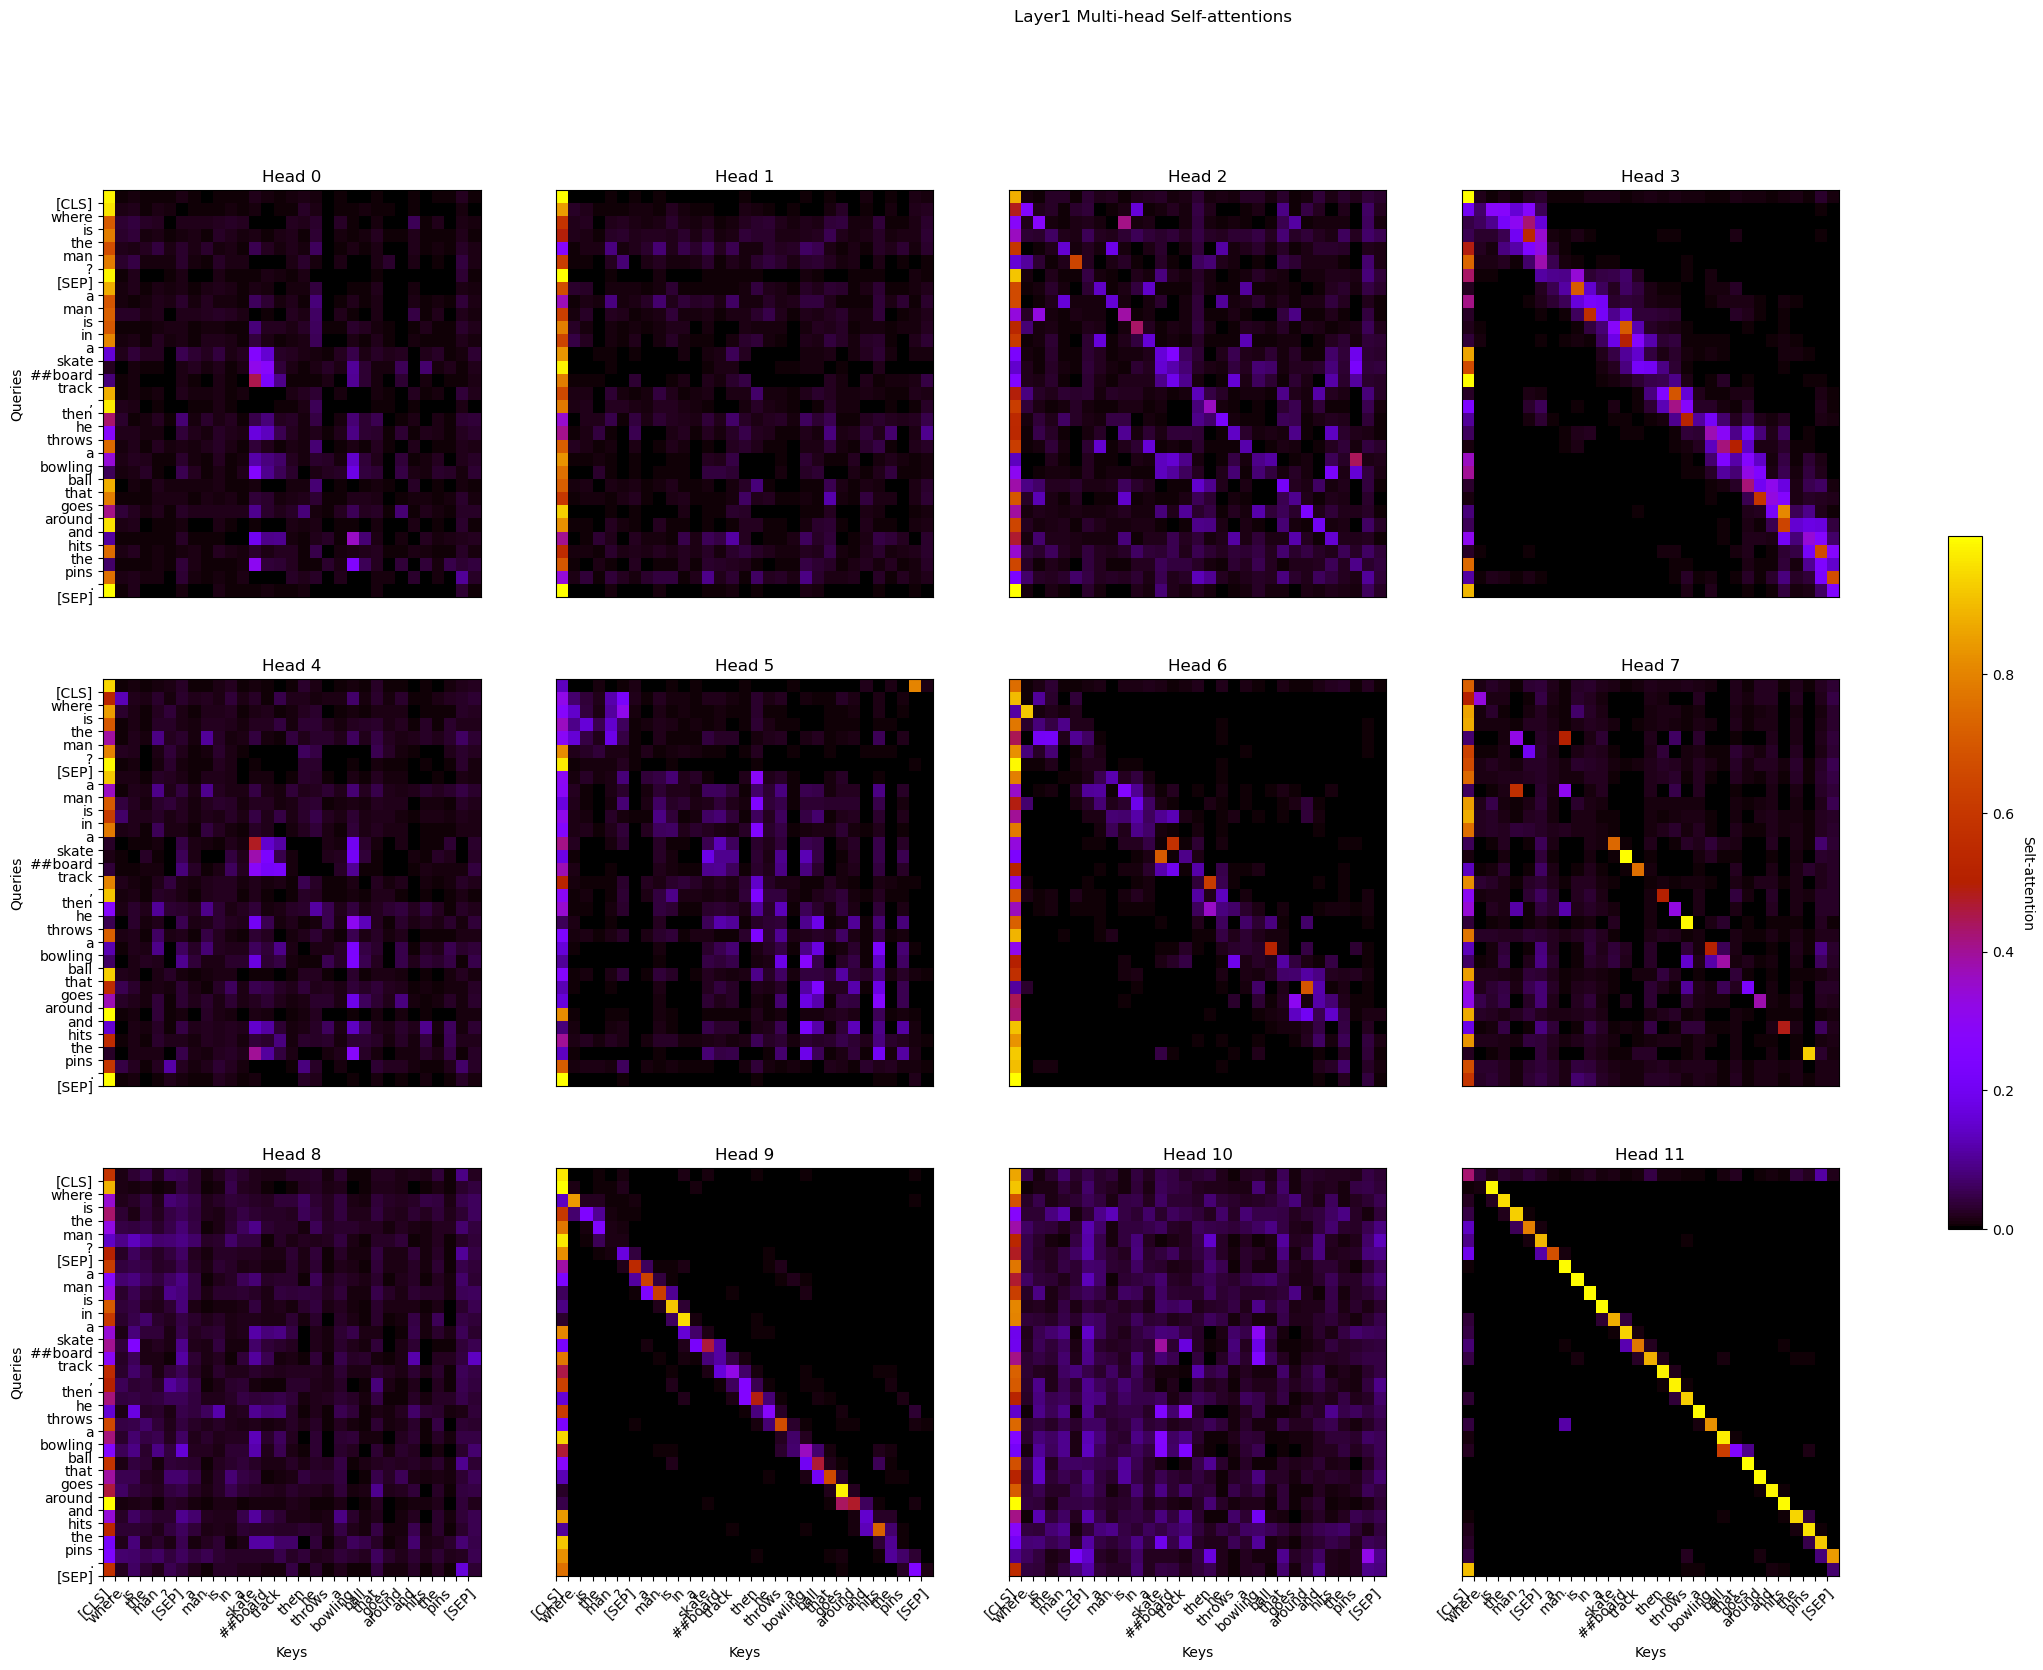

In [32]:
layer = 1

rows = 3
cols = 4
fig, ax_full = plt.subplots(rows, cols)
fig.set_figheight(rows*6)
fig.set_figwidth(cols*6+4)
plt.rcParams.update({'font.size': 10})

j = 0
for r in range(rows):
    for c in range(cols):
       
        ax = ax_full[r,c]
        
        sattention = attention[layer][0][j].numpy()
        sattention = np.flip(sattention, 0)
        
        plt.rcParams.update({'font.size': 10})

        im = ax.pcolormesh(sattention, cmap='gnuplot')

        # Show all ticks and label them with the respective list entries
        ax.set_title("Head " + str(j))
        ax.set_yticks(np.arange(len(tokens)))
        if c == 0:
            ax.set_yticklabels(reversed(tokens))
            ax.set_ylabel("Queries")
        else:
            ax.set_yticks([])

        ax.set_xticks(np.arange(len(tokens)))
        if r == rows-1:
            ax.set_xticklabels(tokens)
            ax.set_xlabel("Keys")
            
            # Rotate the tick labels and set their alignment.
            plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                     rotation_mode="anchor")
        else:
            ax.set_xticks([])

            
        # Loop over data dimensions and create text annotations.
        j = j + 1

fig.suptitle("Layer" + str(layer) + " Multi-head Self-attentions")
cbar = fig.colorbar(im, ax=ax_full, location='right', shrink=0.5)
cbar.ax.set_ylabel("Selt-attention", rotation=-90, va="bottom")
plt.savefig("self_att_heads.eps")
plt.show()

### Attention dual encoder

In [33]:
def generate_caption_embedding_with_attention(caption):
    # Tokenize the input
    inputs = tokenizer(caption, return_tensors='pt', padding=True, truncation=True)
    
    # Forward pass with attention outputs enabled
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True, output_hidden_states=True)
    
    # Extract embeddings (mean pooling)
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    
    # Extract attention weights
    attention = outputs.attentions  # List of attention weights for each layer
    
    return embeddings, attention, inputs

In [37]:
query = "where is the man?"
document = captions[3]

query_inputs, query_outs = generate_caption_embedding_outputs(query)

query_embedding = query_outs.last_hidden_state.mean(dim=1).squeeze().numpy()
query_attention = query_outs.attentions


# Generate embeddings and attention for document
document_inputs, doc_outs = generate_caption_embedding_outputs(document)
document_embedding = doc_outs.last_hidden_state.mean(dim=1).squeeze().numpy()
document_attention = doc_outs.attentions

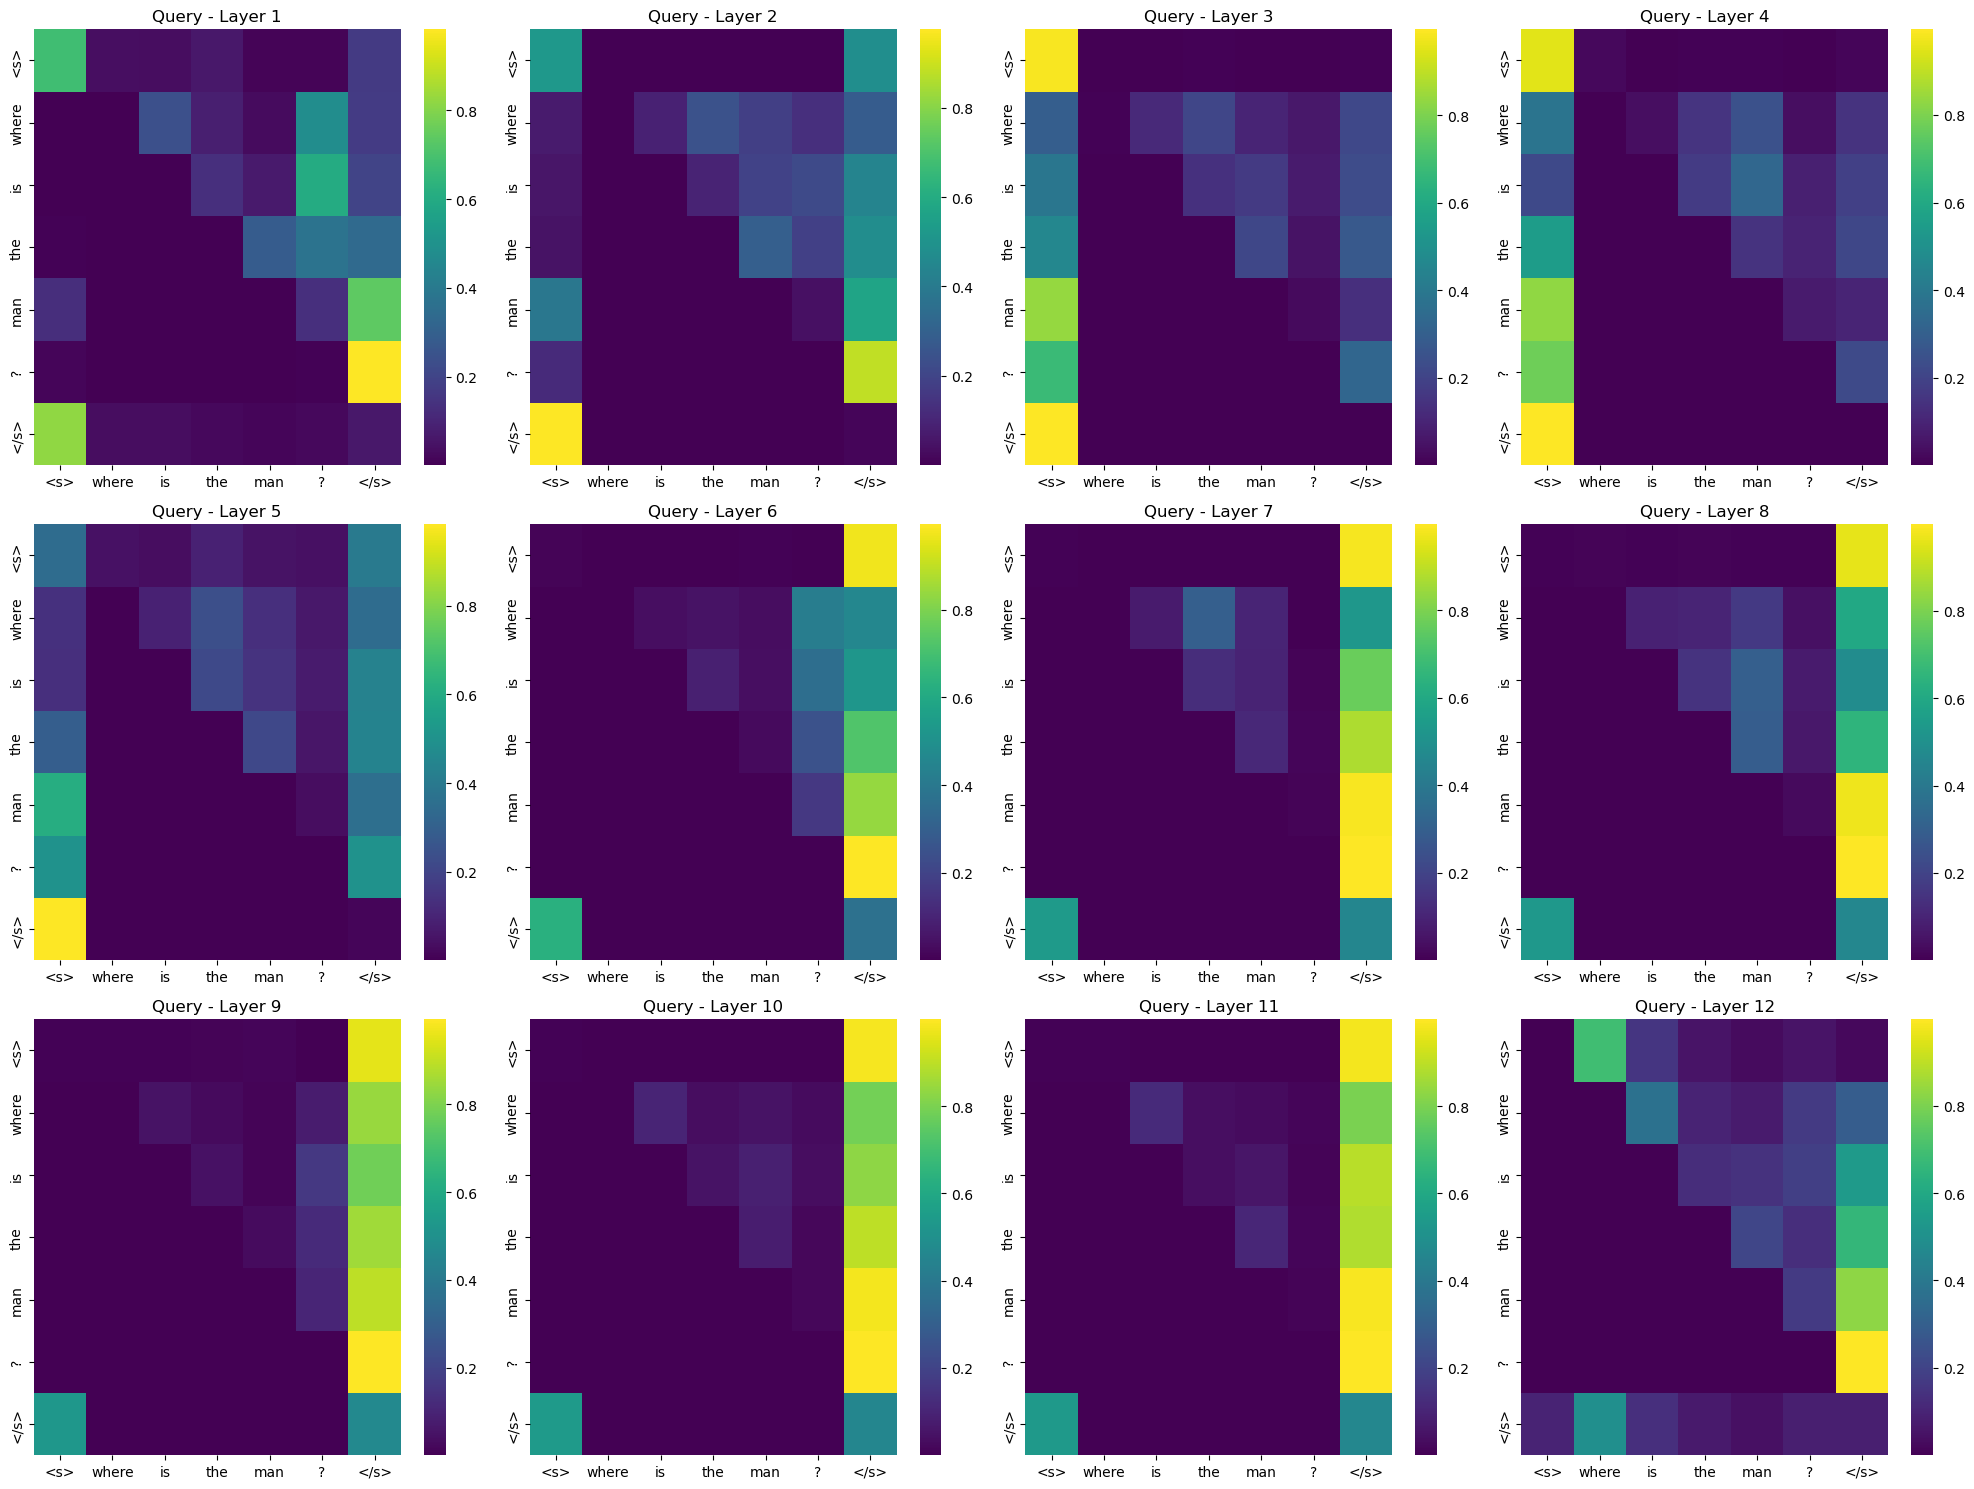

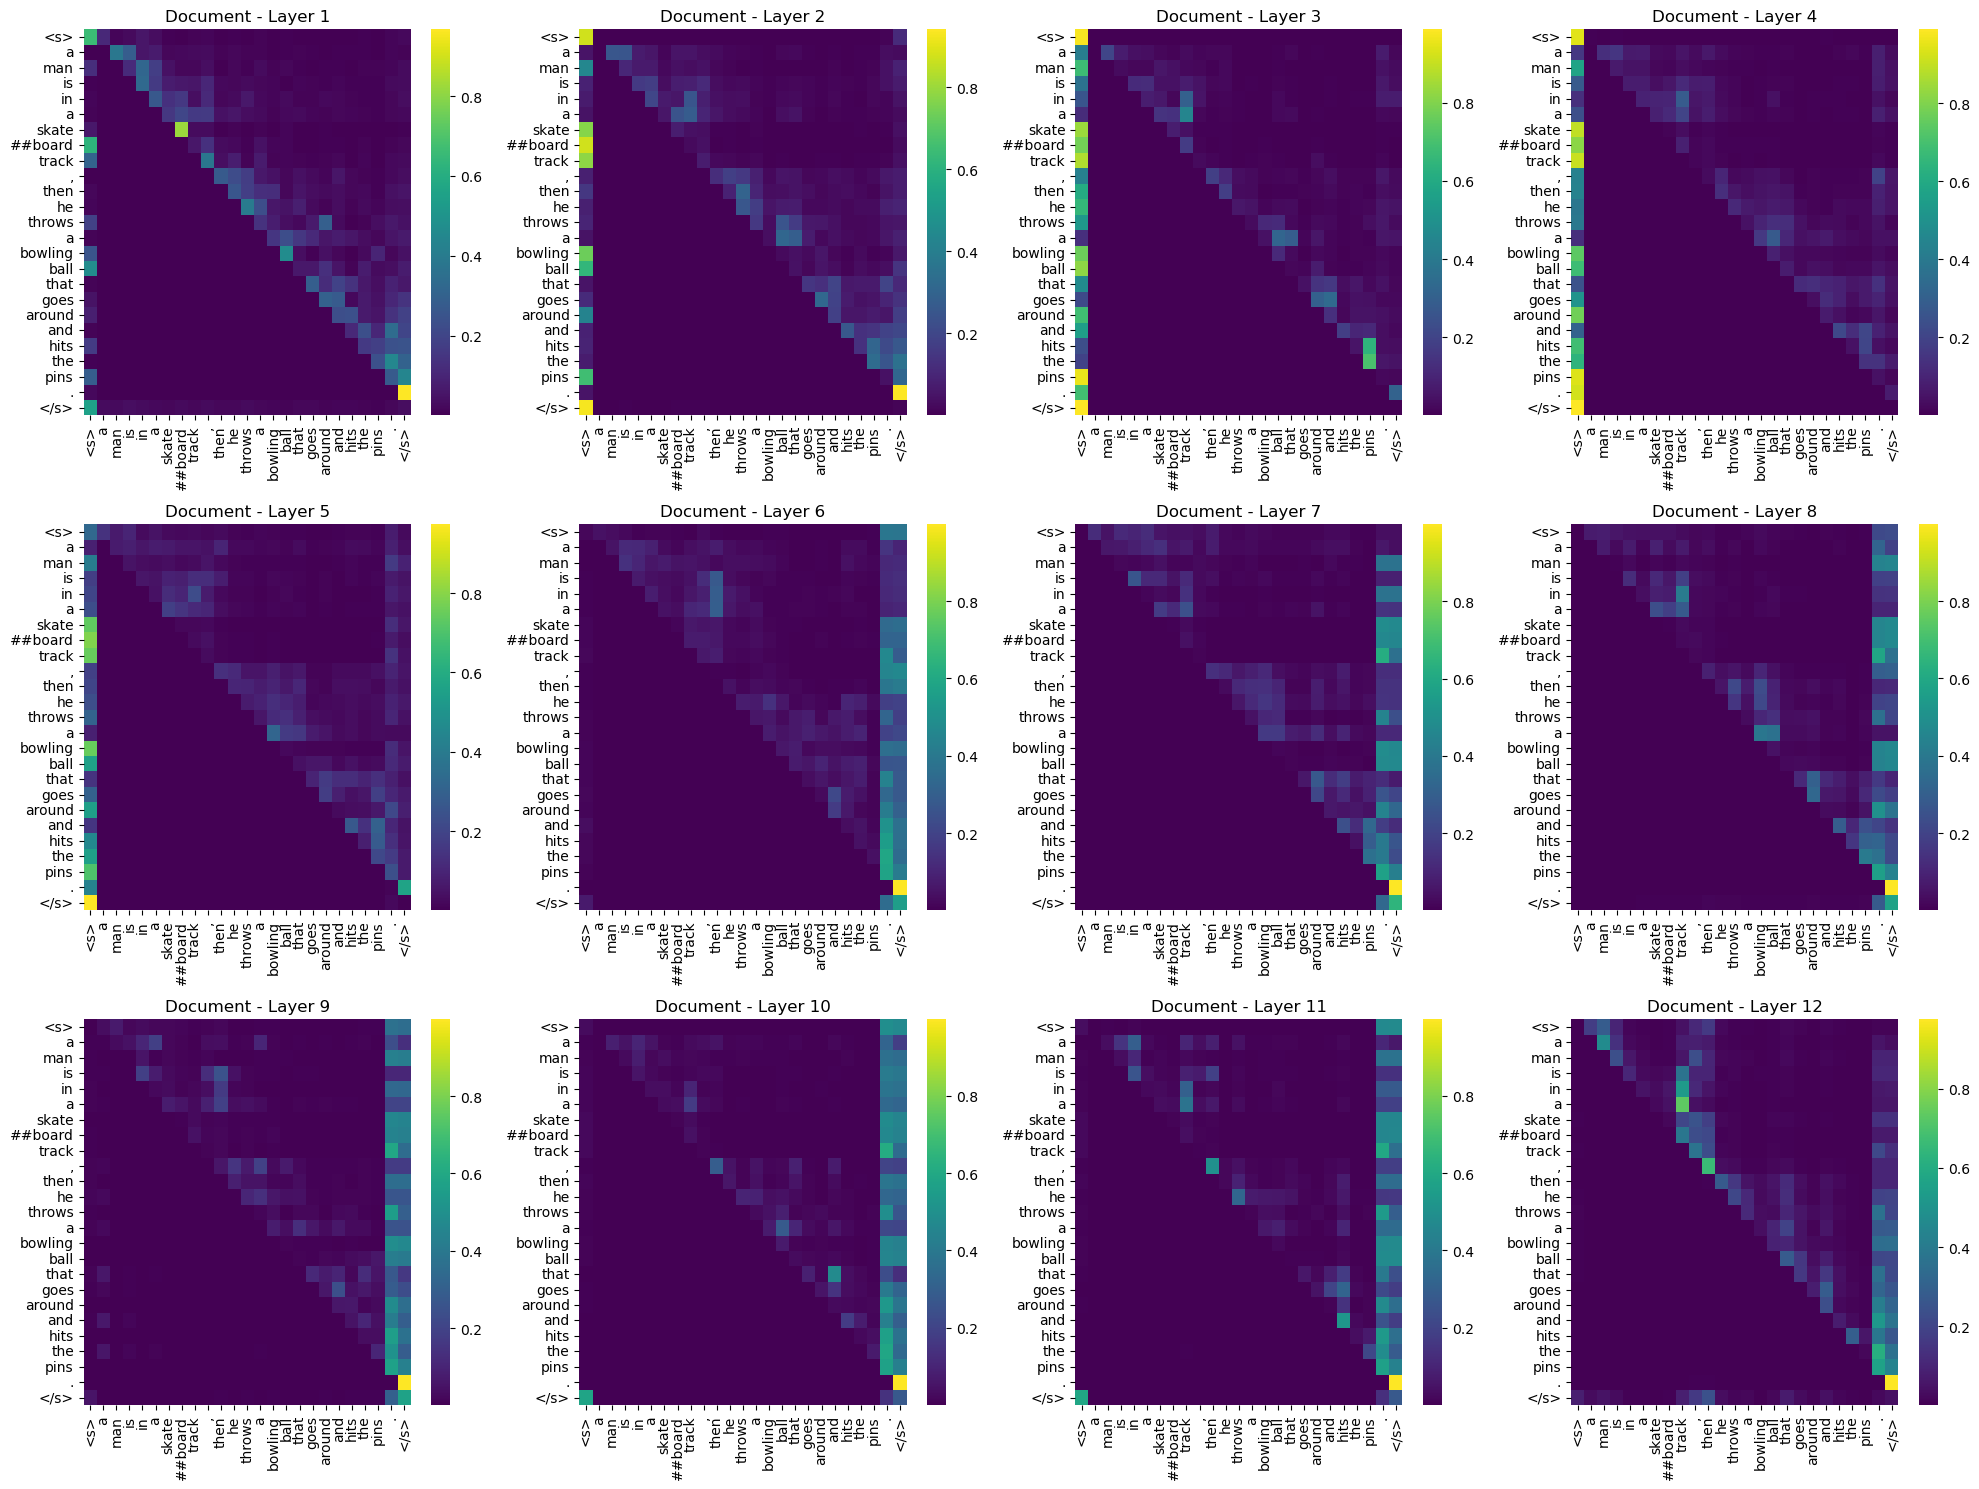

In [42]:
import seaborn as sns

def visualize_attention(attention, inputs, layer=0, head=0):
    # Extract attention weights for the specified layer and head
    attention_weights = attention[layer][0, head].detach().numpy()
    
    # Get token strings
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    
    # Plot the attention heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention_weights, xticklabels=tokens, yticklabels=tokens, cmap="viridis")
    plt.title(f"Self-Attention Weights (Layer {layer + 1}, Head {head + 1})")
    plt.show()

# Visualize attention for all 12 layers for the query
rows, cols = 3, 4
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
for layer in range(12):
    r, c = divmod(layer, cols)
    ax = axes[r, c]
    attention_weights = query_attention[layer][0, 0].detach().numpy()
    tokens = tokenizer.convert_ids_to_tokens(query_inputs['input_ids'][0])
    sns.heatmap(attention_weights, xticklabels=tokens, yticklabels=tokens, cmap="viridis", ax=ax)
    ax.set_title(f"Query - Layer {layer + 1}")
plt.tight_layout()
plt.show()
fig.savefig("attention_layers_query.eps")

# Visualize attention for all 12 layers for the document
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
for layer in range(12):
    r, c = divmod(layer, cols)
    ax = axes[r, c]
    attention_weights = document_attention[layer][0, 0].detach().numpy()
    tokens = tokenizer.convert_ids_to_tokens(document_inputs['input_ids'][0])
    sns.heatmap(attention_weights, xticklabels=tokens, yticklabels=tokens, cmap="viridis", ax=ax)
    ax.set_title(f"Document - Layer {layer + 1}")
plt.tight_layout()
plt.show()
fig.savefig("attention_layers_document.eps")



## Similarity Visualizations

### Caption-Keyframe Similarity Plots

In [11]:
from collections import defaultdict

def get_unique_video_captions_with_vectors(video_id):
    """
    Retrieve unique captions with their visual_caption_vec for a specific video ID.
    
    Args:
        video_id (str): The ID of the video to search for
        index_name (str): Name of the OpenSearch index
        host (str): OpenSearch host
        port (int): OpenSearch port
        
    Returns:
        list: List of unique caption documents with their vectors and timestamp ranges
    """
    
    # Build the query to match the video_id
    query = {
        "size": 10000,
        "query": {
            "term": {
                "video_id": video_id
            }
        },
        "sort": [
            {"start_timestamp": {"order": "asc"}}
        ],
        "_source": ["caption", "start_timestamp", "end_timestamp", "visual_caption_vec"]
    }
    
    # Execute the search
    response = client.search(
        body=query,
        index=index_name
    )
    
    # Process results to handle duplicates while preserving vectors
    hits = response['hits']['hits']
    caption_map = {}
    
    # Group by caption text, keeping vector data
    for hit in hits:
        source = hit['_source']
        caption_text = source['caption']
        
        # If we haven't seen this caption before, store it with all info
        if caption_text not in caption_map:
            caption_map[caption_text] = {
                'caption': caption_text,
                'visual_caption_vec': source['visual_caption_vec'],
                'occurrences': [],
            }
            
        # Add this occurrence's timestamps
        caption_map[caption_text]['occurrences'].append({
            'start_timestamp': source['start_timestamp'],
            'end_timestamp': source['end_timestamp']
        })
    
    # Create final unique caption list with consolidated timestamp ranges
    unique_captions = []
    for caption_data in caption_map.values():
        # Sort occurrences by start_timestamp
        caption_data['occurrences'].sort(key=lambda x: x['start_timestamp'])
        
        # Find min start and max end timestamp for this caption
        min_start = caption_data['occurrences'][0]['start_timestamp']
        max_end = max(occ['end_timestamp'] for occ in caption_data['occurrences'])
        
        unique_captions.append({
            'caption': caption_data['caption'],
            'visual_caption_vec': caption_data['visual_caption_vec'],
            'occurrence_count': len(caption_data['occurrences']),
            'start_timestamp': min_start,
            'end_timestamp': max_end,
            'all_occurrences': caption_data['occurrences']
        })
    
    # Sort by the earliest start timestamp
    unique_captions.sort(key=lambda x: x['start_timestamp'])
    
    return unique_captions

In [12]:
def get_unique_keyframe_vectors(video_id):
    """
    Retrieve unique keyframe paths with their corresponding keyframe_vec values
    for a specific video ID.
    
    Args:
        video_id (str): The ID of the video to search for
        index_name (str): Name of the OpenSearch index
        host (str): OpenSearch host
        port (int): OpenSearch port
        
    Returns:
        list: List of dictionaries containing keyframe_path and keyframe_vec pairs
    """

    # Method 1: Using aggregations (more efficient for large datasets)
    agg_query = {
        "size": 0,
        "query": {
            "term": {
                "video_id": video_id
            }
        },
        "aggs": {
            "unique_keyframes": {
                "terms": {
                    "field": "keyframe_path",
                    "size": 10000  # Adjust based on expected number of keyframes
                },
                "aggs": {
                    "keyframe_details": {
                        "top_hits": {
                            "size": 1,
                            "_source": ["keyframe_path", "keyframe_vec"]
                        }
                    }
                }
            }
        }
    }
    
    response = client.search(
        body=agg_query,
        index=index_name
    )
    
    unique_keyframes = []
    
    # Extract keyframe data from aggregation results
    if 'unique_keyframes' in response.get('aggregations', {}):
        for bucket in response['aggregations']['unique_keyframes']['buckets']:
            keyframe_path = bucket['key']
            hit = bucket['keyframe_details']['hits']['hits'][0]
            keyframe_vec = hit['_source']['keyframe_vec']
            
            unique_keyframes.append({
                'keyframe_path': keyframe_path,
                'keyframe_vec': keyframe_vec
            })
    
    return unique_keyframes

In [13]:
def sort_keyframes(keyframe_dict_array):
    """
    Sort an array of dictionaries by the numeric index in the keyframe_path.
    
    Each dictionary has the format {"keyframe_path": value, "keyframe_vec": value}
    The keyframe_path is of the form: 'QKEFacWrn_8_keyframes/QKEFacWrn_8_83.jpg'
    We extract the number between the last underscore and .jpg (83 in this example)
    
    Args:
        keyframe_dict_array: List of dictionaries with "keyframe_path" as a key
        
    Returns:
        Sorted list of dictionaries
    """
    def extract_index(item):
        # Get the keyframe_path value from the dictionary
        keyframe_path = item["keyframe_path"]
        
        # Extract the filename part after the last slash
        filename = keyframe_path.split('/')[-1]
        
        # Extract the number between the last underscore and .jpg
        index_str = filename.split('_')[-1].split('.')[0]
        
        # Convert to integer for numerical sorting
        return int(index_str)
    
    # Sort the array based on the extracted index
    return sorted(keyframe_dict_array, key=extract_index)


In [30]:
from random import randint
import numpy as np
import matplotlib.pyplot as plt
def get_rand_plot(video_id):
    print("Fetching captions embeddings...")
    cap_embeds = get_unique_video_captions_with_vectors(video_id)
    print("Selecting random caption...")
    cap_index = randint(0, len(cap_embeds)-1)
    random_cap = cap_embeds[cap_index]["caption"]
    print("Fetching keyframe embeddings...")
    keyframe_vecs = get_unique_keyframe_vectors(video_id)
    sorted_arr = sort_keyframes(keyframe_vecs)
    print("Generating similarity plot for: ", random_cap)
    similarity_through_video = []
    for vec in sorted_arr:
        similarity_through_video.append(np.dot(vec["keyframe_vec"], cap_embeds[cap_index]["visual_caption_vec"]))

    plot_points = []
    for i in range(len(similarity_through_video)-2):
        plot_points.append((similarity_through_video[i]+similarity_through_video[i+1]+similarity_through_video[i+2])/3)
    # Create a figure and axis
    plt.figure(figsize=(10, 6))
    
    # Plot the data
    plt.plot(plot_points, color='blue', linewidth=2)
    
    # Add labels and title
    plt.xlabel('Keyframe Index', fontsize=12)
    plt.ylabel('Similarity Value', fontsize=12)
    plt.title('Similarity plot', fontsize=14)
    
    # Add grid for better readability
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Show the plot
    plt.show()
    

Fetching captions embeddings...
Selecting random caption...
Fetching keyframe embeddings...
Generating similarity plot for:    Two men sitting back on chairs talk to each other.


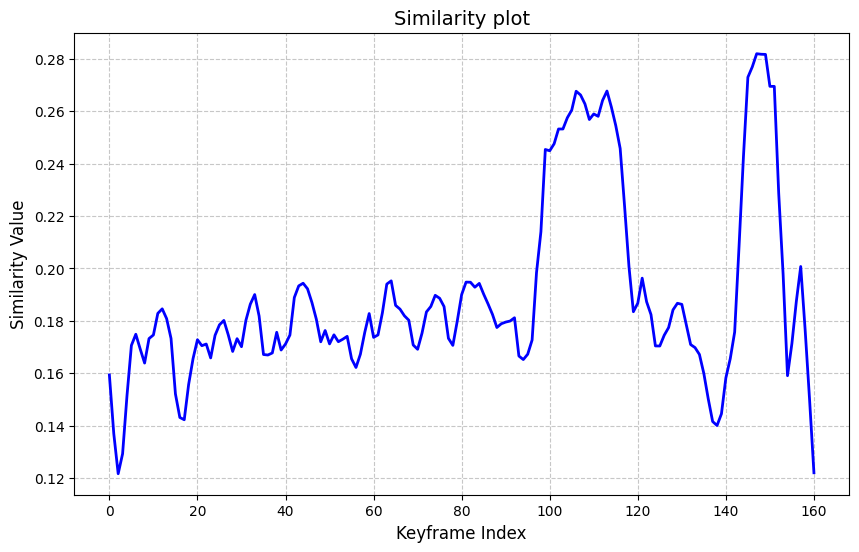

In [32]:
get_rand_plot("QKEFacWrn_8")